<font>
<div dir=ltr align=center>
<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' width=150 height=150> <br>
<font color=0F5298 size=6>
Machine Learning<br>
<font color=2565AE size=4>
Computer Engineering Department<br>
Fall 2025<br>
<font color=3C99D size=4>
Homework 3 - Practical<br>
<font color=696880 size=3>

<font color=696880 size=10>
Mohamadreza Izady - 402110916<br>

# Libraries

In [15]:
import math
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Dataset

In [16]:
def set_seed(seed=42):
    """Return a NumPy Generator for reproducibility."""
    generator = np.random.default_rng(seed)
    return generator
def train_val_split(X, y, val_ratio=0.2, seed=42):
    """Split X, y into train/val using a shuffled index.
    Returns:
        X_train, y_train, X_val, y_val
    """
    generator = set_seed(seed)
    n = X.shape[0]
    idx = np.arange(n)
    generator.shuffle(idx)
    # TO DO
    # Calculate the split point
    val_size = int(n * val_ratio)
    train_size = n - val_size
    
    # Split indices into training and validation
    train_idx = idx[:train_size]
    val_idx = idx[train_size:]
    
    # Use indices to split X and y
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    
    return X_train, y_train, X_val, y_val



def standardize(X_train, X_val):
    """Standardize features using train mean/std and apply to val.
    What to implement:
      - Compute train mean/std per feature.
      - Return normalized X_train and X_val using train stats.
    """
    # TO DO
    # Compute mean and std from training data only (per feature, i.e., along axis 0)
    train_mean = np.mean(X_train, axis=0)
    train_std = np.std(X_train, axis=0)
    
    # Avoid division by zero: replace zero std with 1 (those features are constant)
    train_std[train_std == 0] = 1.0
    
    # Standardize both sets using ONLY training statistics
    X_train_standardized = (X_train - train_mean) / train_std
    X_val_standardized = (X_val - train_mean) / train_std
    
    return X_train_standardized, X_val_standardized

In [17]:
def make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1.0, seed=42):
    """Generate a simple clustered dataset (features X, integer labels y)."""
    # TODO: implement make_blobs
    generator = set_seed(seed)
    
    # Calculate samples per cluster (distribute evenly)
    samples_per_cluster = n_samples // centers
    remainder = n_samples % centers  # Handle case where n_samples not divisible by centers
    
    # Generate random cluster centers
    # Each center is a point in n_features-dimensional space
    # Spread centers out by scaling (e.g., range [-10, 10] for each feature)
    cluster_centers = generator.uniform(-10, 10, size=(centers, n_features))
    
    X_list = []
    y_list = []
    
    for i in range(centers):
        # Determine number of samples for this cluster
        n_cluster_samples = samples_per_cluster + (1 if i < remainder else 0)
        
        # Generate samples from Gaussian distribution centered at cluster_centers[i]
        # np.random.Generator.normal(loc=mean, scale=std, size=shape)
        cluster_samples = generator.normal(
            loc=cluster_centers[i],      # Center of this cluster
            scale=cluster_std,           # Standard deviation (spread)
            size=(n_cluster_samples, n_features)
        )
        
        # Create labels for this cluster (all samples labeled as cluster index i)
        cluster_labels = np.full(n_cluster_samples, i, dtype=int)
        
        X_list.append(cluster_samples)
        y_list.append(cluster_labels)
    
    # Concatenate all clusters
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle the data (so samples aren't ordered by cluster)
    shuffle_idx = np.arange(n_samples)
    generator.shuffle(shuffle_idx)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    return X, y

In [18]:
X, y = make_blobs(n_samples=1200, n_features=10, centers=5, cluster_std=1.3)
X_train_raw, y_train_raw, X_val_raw, y_val_raw = train_val_split(X, y, val_ratio=0.2)
X_train, X_val = standardize(X_train_raw, X_val_raw)
y_train, y_val = y_train_raw, y_val_raw

In [19]:
num_classes = int(y.max() + 1)
input_dim = X_train.shape[1]
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape, 'Classes:', num_classes)

Train shape: (960, 10) Val shape: (240, 10) Classes: 5


# Part 2: MLP Layers

In [20]:
class Layer:
    """Base class for layers.
    Methods to implement in subclasses:
      - forward(x, training=True): returns output tensor
      - backward(dout): returns gradient w.r.t. input (dx)
    Convention:
      - Trainable parameters are kept in self.params (dict)
      - Their gradients are kept in self.grads (dict)
    """
    def __init__(self):
        # You usually do NOT change this part.
        # It provides dictionaries that child classes will fill.
        self.params = {}
        self.grads = {}
    
    def forward(self, x, training=True):
        """
        Forward pass of the layer.
        TODO (in subclasses):
          - Take input x and return the output tensor.
          - Use `training` if the layer behaves differently in train/test
            (e.g., Dropout, BatchNorm).
        This base class just defines the interface and should be overridden.
        """
        raise NotImplementedError("forward() must be implemented in subclasses.")
    
    def backward(self, dout):
        """
        Backward pass of the layer.
        TODO (in subclasses):
          - Take upstream gradient dout and return gradient w.r.t. input (dx).
          - Also fill self.grads[...] for any trainable parameters.
        This base class just defines the interface and should be overridden.
        """
        raise NotImplementedError("backward() must be implemented in subclasses.")
    
    def parameters(self):
        """Yield (name, param_array, grad_array) pairs for trainer/optimizer.
        You typically don't need to modify this:
          - Used by the optimizer to iterate over all trainable params.
        """
        for k, v in self.params.items():
            yield k, v, self.grads[k]

In [21]:
class Linear(Layer):
    """Affine layer: y = xW + b.
    Args:
        - init: 'he' or 'xavier' for weight initialization
    What to implement:
      - forward: cache x, return x @ W + b
      - backward: compute dW = x^T @ dout, db = sum(dout), dx = dout @ W^T
      - store grads in self.grads['W'], self.grads['b']
    """
    def __init__(self, in_features, out_features, init='he', seed=42):
        super().__init__()
        if init == 'xavier':
            scale = math.sqrt(2.0 / (in_features + out_features))
        else:
            # He is the default for ReLU
            scale = math.sqrt(2.0 / in_features)
        generator = np.random.default_rng(seed)
        W = generator.normal(0.0, scale, size=(in_features, out_features)).astype(np.float64)
        b = np.zeros((out_features,), dtype=np.float64)
        self.params['W'] = W
        self.params['b'] = b
        self.grads['W'] = np.zeros_like(W)
        self.grads['b'] = np.zeros_like(b)
        self.cache = None
    
    def forward(self, x, training=True):
        """
        Forward pass of the linear layer.
        TODO:
          1. Cache the input x in self.cache for use in backward.
          2. Compute the affine output:
               out = x @ W + b
             where:
               - W = self.params['W']
               - b = self.params['b']
          3. Return out.
        Hint:
          - Use the @ operator for matrix multiplication.
        """
        # TODO: cache x
        self.cache = x
        
        # TODO: compute out = x @ self.params['W'] + self.params['b']
        W = self.params['W']
        b = self.params['b']
        out = x @ W + b
        
        # TODO: return out
        return out
    
    def backward(self, dout):
        """
        Backward pass of the linear layer.
        Input:
          - dout: upstream gradient with shape (N, out_features)
        TODO:
          1. Retrieve x from self.cache.
          2. Compute gradients:
               dW = x^T @ dout        (shape: (in_features, out_features))
               db = sum(dout, axis=0) (shape: (out_features,))
               dx = dout @ W^T        (shape: (N, in_features))
          3. Store dW and db into:
               self.grads['W'][...] = dW
               self.grads['b'][...] = db
          4. Return dx.
        Hints:
          - Use x.T for transpose of x.
          - Use .sum(axis=0) to sum over the batch dimension.
          - Use self.params['W'] to access W.
        """
        # TODO: get x from self.cache
        x = self.cache
        
        # TODO: compute dW = x.T @ dout
        dW = x.T @ dout
        
        # TODO: compute db = dout.sum(axis=0)
        db = dout.sum(axis=0)
        
        # TODO: store into self.grads['W'] and self.grads['b']
        self.grads['W'][...] = dW
        self.grads['b'][...] = db
        
        # TODO: compute dx = dout @ self.params['W'].T
        dx = dout @ self.params['W'].T
        
        # TODO: return dx
        return dx

In [22]:
class ReLU(Layer):
    """Rectified Linear Unit: ReLU(x) = max(0, x)."""
    def __init__(self):
        super().__init__()
        # Will store a boolean mask of where x > 0
        self.mask = None
    
    def forward(self, x, training=True):
        """
        Forward pass for ReLU.
        TODO:
          1. Create a boolean mask of where x > 0 and store it in self.mask.
             - self.mask should have the same shape as x.
          2. Return the elementwise product x * self.mask
             (which is equivalent to max(0, x) elementwise).
        Hints:
          - Use comparison: x > 0  (this gives a boolean array).
          - NumPy will automatically broadcast boolean mask in x * mask.
        """
        # TODO: self.mask = (x > 0)
        self.mask = (x > 0)
        
        # TODO: out = x * self.mask
        out = x * self.mask
        
        # TODO: return out
        return out
    
    def backward(self, dout):
        """
        Backward pass for ReLU.
        Input:
          - dout: upstream gradient, same shape as the input x.
        TODO:
          1. Use the stored mask from forward (self.mask).
          2. Propagate gradients only where x > 0:
               dx = dout * self.mask
          3. Return dx.
        Hint:
          - Positions where x <= 0 should have zero gradient.
        """
        # TODO: dx = dout * self.mask
        dx = dout * self.mask
        
        # TODO: return dx
        return dx


class Tanh(Layer):
    """Elementwise tanh activation."""
    def __init__(self):
        super().__init__()
        # Will cache the output tanh(x) for use in backward
        self.cache = None
    
    def forward(self, x, training=True):
        """
        Forward pass for tanh.
        TODO:
          1. Compute the tanh of x elementwise.
             - out = np.tanh(x)
          2. Store out in self.cache (for use in backward).
          3. Return out.
        Hint:
          - np.tanh works elementwise on NumPy arrays.
        """
        # TODO: out = np.tanh(x)
        out = np.tanh(x)
        
        # TODO: self.cache = out
        self.cache = out
        
        # TODO: return out
        return out
    
    def backward(self, dout):
        """
        Backward pass for tanh.
        Input:
          - dout: upstream gradient, same shape as x.
        TODO:
          1. Retrieve the cached output: out = self.cache
          2. Use the derivative:
               d/dx tanh(x) = 1 - tanh^2(x)
             so:
               dx = dout * (1 - out * out)
          3. Return dx.
        Hint:
          - out is tanh(x), so out * out is tanh(x)^2.
        """
        # TODO: out = self.cache
        out = self.cache
        
        # TODO: dx = dout * (1 - out * out)
        dx = dout * (1 - out * out)
        
        # TODO: return dx
        return dx

In [23]:
class Dropout(Layer):
    """Inverted Dropout.
    Args:
        p: drop probability in (0, 1). During training, we set some activations
           to zero and scale the rest by 1/(1-p) so expectation stays constant.
    What to implement:
      - forward:
          if training: sample mask from Bernoulli(keep_prob) and scale by 1/(1-p)
                       return x * mask (store mask)
          else: return x unchanged
      - backward:
          if training: return dout * mask
          else: return dout unchanged
    """
    def __init__(self, p=0.5, seed=42):
        super().__init__()
        assert 0.0 <= p < 1.0
        self.p = float(p)
        self.keep = 1.0 - self.p          # keep probability
        self.generator = np.random.default_rng(seed)
        self.mask = None                  # will store dropout mask
    
    def forward(self, x, training=True):
        """
        Forward pass for inverted dropout.
        Inputs:
          - x: input activations
          - training: if False, dropout is disabled (evaluation mode)
        TODO:
          1. If NOT training or p == 0.0:
               - Set self.mask = None
               - Return x unchanged
          2. If training:
               - Sample a mask of the same shape as x from Bernoulli(keep_prob):
                   keep_prob = self.keep
                   raw_mask = (self.generator.random(x.shape) < keep_prob)
               - Convert raw_mask to float and scale by 1 / keep_prob
                   mask = raw_mask.astype(np.float64) / keep_prob
               - Store mask in self.mask
               - Return x * mask (elementwise)
        Notes:
          - This is *inverted* dropout, so at test time we do nothing.
        """
        # TODO: handle eval mode (no dropout)
        if not training or self.p == 0.0:
            self.mask = None
            return x
        
        # TODO: handle training mode (sample + scale mask, store in self.mask, return x * mask)
        # Sample a mask from Bernoulli(keep_prob)
        keep_prob = self.keep
        raw_mask = (self.generator.random(x.shape) < keep_prob)
        
        # Convert to float and scale by 1/keep_prob (inverted dropout)
        mask = raw_mask.astype(np.float64) / keep_prob
        
        # Store mask for backward pass
        self.mask = mask
        
        # Apply mask to input
        return x * mask
    
    def backward(self, dout):
        """
        Backward pass for inverted dropout.
        Input:
          - dout: upstream gradient (same shape as x)
        TODO:
          1. If self.mask is None (eval mode or p == 0):
               - Just return dout unchanged
          2. Otherwise (training mode):
               - Return dout * self.mask
        Hint:
          - The same mask used in forward is applied to the gradient.
        """
        # TODO: if self.mask is None: return dout
        if self.mask is None:
            return dout
        
        # TODO: else: return dout * self.mask
        return dout * self.mask

In [24]:
class BatchNorm1d(Layer):
    """Batch Normalization for 2D inputs (N, D).

    What to implement:
      - forward (train): compute batch mean/var, normalize, scale/shift by gamma/beta,
                         update running stats (mean/var), cache intermediates
      - forward (eval): normalize using running stats
      - backward: gradients for gamma/beta and dx via BN derivatives
    """

    def __init__(self, num_features, momentum=0.9, eps=1e-5):
        super().__init__()

        # Learnable scale and shift parameters
        self.params['gamma'] = np.ones((num_features,), dtype=np.float64)
        self.params['beta'] = np.zeros((num_features,), dtype=np.float64)
        self.grads['gamma'] = np.zeros_like(self.params['gamma'])
        self.grads['beta'] = np.zeros_like(self.params['beta'])

        # Running statistics for inference
        self.momentum = momentum
        self.eps = eps
        self.running_mean = np.zeros((num_features,), dtype=np.float64)
        self.running_var = np.ones((num_features,), dtype=np.float64)

        # To store intermediates needed in backward
        self.cache = None

    def forward(self, x, training=True):
        """
        Forward pass for BatchNorm1d.

        Input:
          - x: array of shape (N, D)
          - training: bool, True for train mode, False for eval mode

        TODO (training=True):
          1. Compute batch mean and variance along axis=0:
               mu = x.mean(axis=0)
               var = x.var(axis=0)
          2. Normalize x:
               x_mu = x - mu
               std_inv = 1.0 / np.sqrt(var + self.eps)
               x_hat = x_mu * std_inv
          3. Scale and shift using gamma and beta:
               out = gamma * x_hat + beta
             where:
               gamma = self.params['gamma']
               beta  = self.params['beta']
          4. Update running statistics:
               self.running_mean = momentum * self.running_mean + (1 - momentum) * mu
               self.running_var  = momentum * self.running_var  + (1 - momentum) * var
          5. Cache intermediates needed for backward:
               self.cache = (x, x_hat, mu, var, std_inv)
          6. Return out.

        TODO (training=False):
          1. Use running_mean and running_var to normalize:
               x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
          2. Scale and shift:
               out = gamma * x_hat + beta
          3. Return out.
        """
        # TODO: implement train and eval branches as described
        gamma = self.params['gamma']
        beta = self.params['beta']
        
        if training:
            # Step 1: Compute batch mean and variance
            mu = x.mean(axis=0)
            var = x.var(axis=0)
            
            # Step 2: Normalize
            x_mu = x - mu
            std_inv = 1.0 / np.sqrt(var + self.eps)
            x_hat = x_mu * std_inv
            
            # Step 3: Scale and shift
            out = gamma * x_hat + beta
            
            # Step 4: Update running statistics (exponential moving average)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
            
            # Step 5: Cache intermediates for backward pass
            self.cache = (x, x_hat, mu, var, std_inv)
            
            # Step 6: Return output
            return out
        
        else:
            # Evaluation mode: use running statistics
            # Step 1: Normalize using running stats
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            
            # Step 2: Scale and shift
            out = gamma * x_hat + beta
            
            # Step 3: Return output
            return out

    def backward(self, dout):
        """
        Backward pass for BatchNorm1d.

        Input:
          - dout: upstream gradient of shape (N, D)

        From cache, you should have:
          x, x_hat, mu, var, std_inv = self.cache
          gamma = self.params['gamma']
          N, D = x.shape

        TODO:
          1. Unpack cache: x, x_hat, mu, var, std_inv.
          2. Compute gradients w.r.t. gamma and beta:
               dgamma = sum(dout * x_hat, axis=0)
               dbeta  = sum(dout, axis=0)
             Store them in:
               self.grads['gamma'][...] = dgamma
               self.grads['beta'][...]  = dbeta
          3. Backprop through the normalization:
               dx_hat = dout * gamma

             Then use the standard BN derivatives:
               dvar = sum(dx_hat * (x - mu), axis=0) * (-0.5) * (std_inv ** 3)
               dmu  = sum(dx_hat * -std_inv, axis=0) + dvar * mean(-2 * (x - mu), axis=0)
               dx   = dx_hat * std_inv + dvar * 2 * (x - mu) / N + dmu / N

          4. Return dx.

        Hints:
          - Pay close attention to shapes; all operations are elementwise over D.
          - Use np.sum(..., axis=0) and np.mean(..., axis=0) where indicated.
        """
        # TODO: unpack cache
        x, x_hat, mu, var, std_inv = self.cache
        gamma = self.params['gamma']
        N, D = x.shape
        
        # TODO: compute dgamma and dbeta, store in self.grads
        dgamma = np.sum(dout * x_hat, axis=0)
        dbeta = np.sum(dout, axis=0)
        self.grads['gamma'][...] = dgamma
        self.grads['beta'][...] = dbeta
        
        # TODO: compute dx_hat = dout * gamma
        dx_hat = dout * gamma
        
        # TODO: compute dvar, dmu, dx as in the formulas above
        # Gradient w.r.t. variance
        x_mu = x - mu
        dvar = np.sum(dx_hat * x_mu, axis=0) * (-0.5) * (std_inv ** 3)
        
        # Gradient w.r.t. mean
        dmu = np.sum(dx_hat * -std_inv, axis=0) + dvar * np.mean(-2 * x_mu, axis=0)
        
        # Gradient w.r.t. input x
        dx = dx_hat * std_inv + dvar * 2 * x_mu / N + dmu / N
        
        # TODO: return dx
        return dx

# Part 3: Loss

In [25]:
def softmax_cross_entropy(logits, y):
    """Stable softmax + cross-entropy for integer labels.
    Inputs:
      - logits: shape (N, C)
      - y: int labels in [0, C-1], shape (N,)
    Returns:
      - loss (scalar), dlogits (shape (N, C))
    What to implement:
      - shift logits by row max for stability
      - compute softmax probs, CE loss, and gradient dL/dlogits
    """
    # TODO 1: For numerical stability, shift logits by the max value in each row.
    #   - Let shifted = logits - logits.max(axis=1, keepdims=True)
    shifted = logits - logits.max(axis=1, keepdims=True)
    
    # TODO 2: Compute exponentials of the shifted logits.
    #   - exp = np.exp(shifted)
    exp = np.exp(shifted)
    
    # TODO 3: Compute softmax probabilities.
    #   - probs = exp / exp.sum(axis=1, keepdims=True)
    #   Shape of probs should be (N, C).
    probs = exp / exp.sum(axis=1, keepdims=True)
    
    # TODO 4: Compute the cross-entropy loss.
    #   - N = logits.shape[0]
    #   - For each sample i, the correct class probability is probs[i, y[i]]
    #   - Use a small epsilon for numerical stability, e.g. 1e-12
    #   - loss = -np.log(probs[np.arange(N), y] + 1e-12).mean()
    N = logits.shape[0]
    # probs[np.arange(N), y] selects the probability of the correct class for each sample
    correct_class_probs = probs[np.arange(N), y]
    loss = -np.log(correct_class_probs + 1e-12).mean()
    
    # TODO 5: Compute the gradient dL/dlogits (dlogits).
    #   - Start from dlogits = probs.copy()  (conceptually)
    #   - For each sample i, subtract 1 from the probability of the true class:
    #       dlogits[i, y[i]] -= 1
    #   - Divide by N to get the mean gradient:
    #       dlogits /= N
    dlogits = probs.copy()
    dlogits[np.arange(N), y] -= 1  # Subtract 1 from correct class
    dlogits /= N  # Average over batch
    
    # TODO 6: Return loss and dlogits.
    #   - return loss, dlogits
    return loss, dlogits

# Part 4: MLP

In [26]:
class MLP:
    """Multi-Layer Perceptron with optional BatchNorm and Dropout.

    Construction:
      dims = [input_dim] + hidden_sizes + [num_classes]
      For each hidden layer i:
        Linear(dims[i], dims[i+1]) -> [BatchNorm] -> Activation -> [Dropout]
      Output layer is Linear -> logits

    Args:
      activation: 'relu' or 'tanh'
      use_batchnorm: insert BatchNorm before activation if True
      dropout_p: probability to drop activations (0.0 disables)
      init: 'he' or 'xavier' for Linear layers
    """

    def __init__(self, input_dim, hidden_sizes, num_classes,
                 activation='relu', use_batchnorm=False, dropout_p=0.0, init='he', seed=42):
        # You usually don't need to change this constructor.
        # It builds a sequence of layers (Linear / BatchNorm / Activation / Dropout).
        self.layers = []
        generator = np.random.default_rng(seed)
        act_cls = ReLU if activation == 'relu' else Tanh
        dims = [input_dim] + list(hidden_sizes) + [num_classes]

        for i in range(len(dims) - 1):
            # Linear layer
            self.layers.append(
                Linear(dims[i], dims[i + 1], init=init, seed=int(generator.integers(0, 1e9)))
            )
            # Hidden layers: optional BatchNorm + Activation + optional Dropout
            if i < len(dims) - 2:
                if use_batchnorm:
                    self.layers.append(BatchNorm1d(dims[i + 1]))
                self.layers.append(act_cls())
                if dropout_p and dropout_p > 0.0:
                    self.layers.append(Dropout(p=dropout_p, seed=int(generator.integers(0, 1e9))))

        self.training = True

    def forward(self, x, training=True):
        """
        Forward pass of the MLP.

        Input:
          - x: input data of shape (N, input_dim)
          - training: bool flag (True in training, False in eval)

        TODO:
          1. Start with out = x
          2. Loop over all layers in self.layers in order.
          3. For each layer, call its forward method:
               out = layer.forward(out, training=training)
          4. After the loop, return out (these are the logits).

        Hint:
          - Remember to pass along the 'training' flag so that
            BatchNorm and Dropout behave correctly.
        """
        # TODO: implement forward pass through all layers
        out = x
        for layer in self.layers:
            out = layer.forward(out, training=training)
        return out

    def backward(self, dout):
        """
        Backward pass of the MLP.

        Input:
          - dout: gradient of loss with respect to the output logits

        TODO:
          1. Loop over layers in reverse order (use reversed(self.layers)).
          2. For each layer, call its backward method:
               dout = layer.backward(dout)
          3. After the loop, return dout (gradient w.r.t. input x).

        Hint:
          - The backward pass of each layer returns the gradient
            with respect to its input, which becomes dout for the
            previous layer.
        """
        # TODO: implement backward pass through all layers in reverse
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def parameters(self):
        """
        Yield all (id, name, param, grad, layer) tuples for optimizers.

        TODO:
          1. Iterate over all layers in self.layers.
          2. Check if the layer is an instance of Layer (has params).
          3. For each such layer, iterate over layer.parameters()
             which yields (name, param, grad).
          4. For each parameter, yield:
               (id(param), name, param, grad, layer)

        Hint:
          - This is a generator function; use 'yield' not 'return'.
        """
        # TODO: yield (id, name, param, grad, layer) for all trainable params
        for layer in self.layers:
            # Check if layer has parameters (is instance of Layer with params dict)
            if isinstance(layer, Layer):
                for name, param, grad in layer.parameters():
                    yield (id(param), name, param, grad, layer)

    def zero_grads(self):
        """
        Zero all parameter gradients.

        TODO:
          1. Iterate over self.parameters().
          2. For each tuple (_, _, _, grad, _), set grad[...] = 0.0
             so that gradients from the previous batch do not accumulate.

        Hint:
          - Use in-place assignment (grad[...]) not re-binding grad.
        """
        # TODO: loop over parameters and zero out all grad arrays
        for _, _, _, grad, _ in self.parameters():
            grad[...] = 0.0

    def predict(self, x):
        """
        Return argmax class predictions (eval mode).

        Input:
          - x: input data

        TODO:
          1. Run a forward pass in evaluation mode:
               logits = self.forward(x, training=False)
          2. Take the argmax along the class dimension (axis=1):
               preds = logits.argmax(axis=1)
          3. Return preds.

        Hint:
          - This should NOT apply dropout / batchnorm in training mode.
        """
        # TODO: implement prediction using forward(..., training=False)
        logits = self.forward(x, training=False)
        preds = logits.argmax(axis=1)
        return preds

    def accuracy(self, x, y):
        """
        Compute classification accuracy.

        Inputs:
          - x: input data
          - y: true integer labels of shape (N,)

        TODO:
          1. Get predictions using self.predict(x).
          2. Compare preds with y and compute the mean of correct predictions:
               acc = (preds == y).mean()
          3. Return acc (a scalar float in [0, 1]).

        Hint:
          - Use elementwise comparison and .mean().
        """
        # TODO: implement accuracy computation
        preds = self.predict(x)
        acc = (preds == y).mean()
        return acc

## Numerical gradient check (sanity)
We compare analytical gradients vs. finite differences on a tiny network and batch.

In [27]:
def numerical_grad_check(model, X_batch, y_batch, eps=1e-5, atol=1e-6, rtol=1e-3, verbose=False):
    """Finite-difference gradient check.
    What to implement:
      - Forward to compute loss and analytical grads (via backward)
      - For a few random parameter entries: perturb +-eps and estimate numeric grad
      - Compare numeric vs. analytic with tolerances
    Inputs:
      - model: an object with forward, backward, zero_grads, and parameters() methods
      - X_batch: input batch, shape (N, D)
      - y_batch: integer labels, shape (N,)
      - eps: finite-difference step size
      - atol, rtol: absolute and relative tolerances for np.isclose
      - verbose: if True, print details on any mismatched gradients
    Returns:
      - ok: True if all checked gradients are close, False otherwise
    """
    # TODO 1: Run a forward pass through the model to get logits.
    #   - logits = model.forward(X_batch, training=True)
    logits = model.forward(X_batch, training=True)
    
    # TODO 2: Compute the loss and the gradient w.r.t. logits using softmax_cross_entropy.
    #   - loss, dout = softmax_cross_entropy(logits, y_batch)
    loss, dout = softmax_cross_entropy(logits, y_batch)
    
    # TODO 3: Zero out all gradients in the model.
    #   - model.zero_grads()
    model.zero_grads()
    
    # TODO 4: Run a backward pass to fill analytic gradients in model parameters.
    #   - model.backward(dout)
    model.backward(dout)
    
    # TODO 5: Initialize a flag ok = True to track if all checks pass.
    ok = True
    
    # TODO 6: Loop over all parameters using model.parameters():
    for pid, name, param, grad, layer in model.parameters():
        # Skip if grad is None or param is None.
        if grad is None or param is None:
            continue
        
        # Flatten param and grad to 1D views:
        flat = param.reshape(-1)
        gflat = grad.reshape(-1)
        
        # Choose up to 5 random indices to check using a fixed RNG seed for reproducibility:
        rng = np.random.default_rng(0)
        idxs = rng.choice(len(flat), size=min(5, len(flat)), replace=False)
        
        # TODO 7: For each chosen index idx:
        for idx in idxs:
            # Save the original value
            old = flat[idx]
            
            # Compute loss_pos:
            flat[idx] = old + eps
            logits_pos = model.forward(X_batch, training=True)
            loss_pos, _ = softmax_cross_entropy(logits_pos, y_batch)
            
            # Compute loss_neg:
            flat[idx] = old - eps
            logits_neg = model.forward(X_batch, training=True)
            loss_neg, _ = softmax_cross_entropy(logits_neg, y_batch)
            
            # Restore original value
            flat[idx] = old
            
            # Compute numerical gradient:
            g_num = (loss_pos - loss_neg) / (2 * eps)
            
            # Get analytic gradient:
            g_ana = gflat[idx]
            
            # TODO 8: Compare numeric vs analytic using np.isclose:
            if not np.isclose(g_num, g_ana, atol=atol, rtol=rtol):
                ok = False
                if verbose:
                    print(f"Grad mismatch in {layer.__class__.__name__}.{name}: "
                          f"numeric={g_num:.6e}, analytic={g_ana:.6e}")
    
    # TODO 9: After checking all parameters and indices, return ok.
    return ok

In [28]:
# Run a quick check (no dropout during grad check)
Xb = X_train[:8].astype(np.float64)
yb = y_train[:8]

tiny = MLP(input_dim=input_dim, hidden_sizes=[8], num_classes=num_classes,
           activation='relu', use_batchnorm=True, dropout_p=0.0, init='he', seed=123)

ok = numerical_grad_check(tiny, Xb, yb, eps=1e-6, atol=1e-8, rtol=1e-5, verbose=True)

print('Gradient check passed?', ok)

Gradient check passed? True


# Part 4: Optimizers
We implement: SGD, Momentum, Nesterov, RMSProp, Adam, AdamW (decoupled weight decay).

In [29]:
class Optimizer:
    """Base optimizer holding a learning rate and per-parameter state.

    What to implement (in subclasses):
      - step(params_and_grads):
          * Iterate over (pid, param, grad, layer_state) or similar tuples.
          * For each parameter:
              - Use self._get_state(pid) to access per-parameter state dict.
              - Read / initialize any state you need (e.g., momentum, v, m, etc.).
              - Apply your update rule:
                    param[...] = param + update   (usually minus lr * grad)
    """

    def __init__(self, lr=1e-2):
        # Global learning rate for this optimizer
        self.lr = lr
        # Per-parameter state, keyed by parameter id (pid)
        self.state = {}

    def step(self, params_and_grads):
        """
        Apply one update step to all parameters.

        TODO (in subclasses):
          1. Loop over all (pid, name, param, grad, layer) in params_and_grads.
          2. Skip parameters with grad is None.
          3. Use self._get_state(pid) to get a dict for this parameter's state.
             - Example for SGD with momentum:
                 st = self._get_state(pid)
                 if 'velocity' not in st:
                     st['velocity'] = np.zeros_like(param)
          4. Compute the update based on grad, lr (and state if needed).
          5. Apply the update in-place to param, e.g.:
                 param[...] -= self.lr * grad
          6. Do NOT return anything (conventionally step() returns None).
        """
        raise NotImplementedError("step() must be implemented in subclasses.")

    def _get_state(self, pid):
        """Return (and lazily create) a state dict for parameter with id=pid."""
        if pid not in self.state:
            self.state[pid] = {}
        return self.state[pid]


In [30]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD)
    For each parameter w with gradient g at step t:
      w = w - lr * g
    What to implement:
      - In step():
          * Loop over all (pid, name, param, grad, layer) in params_and_grads
          * Update each parameter in-place with:
                param[...] = param - lr * grad
  """
    def step(self, params_and_grads):
        """
        Apply one SGD update to all parameters.
        Inputs:
          - params_and_grads: iterable of
                (pid, name, param, grad, layer)
        TODO:
          1. Loop over all entries in params_and_grads.
          2. For each (pid, name, p, g, layer):
               - Optionally skip if g is None.
               - Update the parameter p in-place:
                    p[...] = p - self.lr * g
        Hint:
          - Use p[...] instead of p = ... to modify the array in-place.
        """
        # TODO: implement plain SGD update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Update parameter in-place: θ = θ - α * g
            p[...] = p - self.lr * g

In [31]:
class SGDMomentum(Optimizer):
    """SGD with momentum (Polyak)
    State per parameter: velocity v.
    Update at step t:
      v = mu * v - lr * g
      w = w + v
    Where mu is momentum in [0, 1).
    """
    def __init__(self, lr=1e-2, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum
    
    def step(self, params_and_grads):
        """
        Apply one SGD-with-momentum update to all parameters.
        Inputs:
          - params_and_grads: iterable of
                (pid, name, param, grad, layer)
        TODO:
          1. Loop over all (pid, name, p, g, layer) in params_and_grads.
          2. For each parameter:
               - Optionally skip if g is None.
               - Get (or create) its state dict:
                    st = self._get_state(pid)
               - Get velocity from state, defaulting to zeros of same shape:
                    v = st.get('v', np.zeros_like(p))
               - Update velocity using:
                    v = self.momentum * v - self.lr * g
               - Update parameter using:
                    p[...] = p + v
               - Store updated velocity back into state:
                    st['v'] = v
        Hint:
          - Use np.zeros_like(p) for initializing v.
          - Use p[...] for in-place update.
        """
        # TODO: implement SGD with momentum as described above
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Get velocity from state, defaulting to zeros if first time
            v = st.get('v', np.zeros_like(p))
            
            # Update velocity: v = μ * v - α * g
            v = self.momentum * v - self.lr * g
            
            # Update parameter: θ = θ + v
            p[...] = p + v
            
            # Store updated velocity back into state
            st['v'] = v

In [32]:
class Nesterov(Optimizer):
    """Nesterov accelerated gradient (lookahead momentum)
    State per parameter: velocity v.
    Practical single-gradient update (equivalent to lookahead form):
      v_t = mu * v_prev - lr * g_t
      w_{t+1} = w_t + ( -mu * v_prev + (1 + mu) * v_t )
    This matches computing the gradient at the lookahead point
    (w_t + mu * v_prev) without an extra forward/backward pass.
    """
    def __init__(self, lr=1e-2, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum
    
    def step(self, params_and_grads):
        """
        Apply one Nesterov accelerated gradient update to all parameters.
        Inputs:
          - params_and_grads: iterable of
                (pid, name, param, grad, layer)
        TODO:
          1. Loop over all (pid, name, p, g, layer) in params_and_grads.
          2. For each parameter:
               - Optionally skip if g is None.
               - Get (or create) its state dict:
                    st = self._get_state(pid)
               - Get previous velocity from state, defaulting to zeros:
                    v_prev = st.get('v', np.zeros_like(p))
               - Compute new velocity:
                    v = self.momentum * v_prev - self.lr * g
               - Update parameter using Nesterov rule:
                    p[...] = p + (-self.momentum * v_prev + (1 + self.momentum) * v)
               - Store updated velocity back to state:
                    st['v'] = v
        Hint:
          - Use np.zeros_like(p) for initializing v_prev.
          - Use p[...] to update parameters in-place.
        """
        # TODO: implement Nesterov accelerated gradient update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Get previous velocity from state, defaulting to zeros
            v_prev = st.get('v', np.zeros_like(p))
            
            # Compute new velocity: v = μ * v_prev - α * g
            v = self.momentum * v_prev - self.lr * g
            
            # Update parameter using Nesterov rule:
            # θ = θ + (-μ * v_prev + (1 + μ) * v)
            p[...] = p + (-self.momentum * v_prev + (1 + self.momentum) * v)
            
            # Store updated velocity back to state
            st['v'] = v

In [33]:
class RMSProp(Optimizer):
    """RMSProp
    State per parameter: s (running average of squared gradients).
    Update at step t:
      s = rho * s + (1 - rho) * (g^2)
      w = w - lr * g / (sqrt(s) + eps)
    Typical values: rho=0.9, eps=1e-8.
    """
    def __init__(self, lr=1e-3, rho=0.9, eps=1e-8):
        super().__init__(lr)
        self.rho = rho
        self.eps = eps
    
    def step(self, params_and_grads):
        """
        Apply one RMSProp update to all parameters.
        Inputs:
          - params_and_grads: iterable of
                (pid, name, param, grad, layer)
        TODO:
          1. Loop over all (pid, name, p, g, layer) in params_and_grads.
          2. For each parameter:
               - Optionally skip if g is None.
               - Get (or create) its state dict:
                    st = self._get_state(pid)
               - Retrieve running average of squared gradients, defaulting to zeros:
                    cache = st.get('cache', np.zeros_like(p))
               - Update running average:
                    cache = self.rho * cache + (1 - self.rho) * (g * g)
               - Compute parameter update:
                    p[...] = p - self.lr * g / (np.sqrt(cache) + self.eps)
               - Store updated cache back into state:
                    st['cache'] = cache
        Hints:
          - Use np.zeros_like(p) for initializing cache.
          - Use elementwise operations with NumPy.
          - Use p[...] to ensure in-place update of the parameter.
        """
        # TODO: implement RMSProp update as described above
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Retrieve running average of squared gradients, defaulting to zeros
            cache = st.get('cache', np.zeros_like(p))
            
            # Update running average: s = ρ * s + (1 - ρ) * g²
            cache = self.rho * cache + (1 - self.rho) * (g * g)
            
            # Compute parameter update: θ = θ - α * g / (√s + ε)
            p[...] = p - self.lr * g / (np.sqrt(cache) + self.eps)
            
            # Store updated cache back into state
            st['cache'] = cache

In [34]:
class Adam(Optimizer):
    """Adam (with optional decoupled weight decay, AdamW)
    State per parameter: first moment m, second moment v, time step t.
    Moment updates at step t:
      m = beta1 * m + (1 - beta1) * g
      v = beta2 * v + (1 - beta2) * (g^2)
    Bias correction:
      m_hat = m / (1 - beta1**t)
      v_hat = v / (1 - beta2**t)
    Parameter update:
      w = w - lr * m_hat / (sqrt(v_hat) + eps)
    Decoupled weight decay (AdamW):
      if decoupled and weight_decay > 0:
          w = w - lr * weight_decay * w
      then apply the Adam step above.
    Typical values: beta1=0.9, beta2=0.999, eps=1e-8.
    """
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0, decoupled=False):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        # AdamW when True
        self.decoupled = decoupled
        # Global time step (starts at 0, incremented each step)
        self.t = 0
    
    def step(self, params_and_grads):
        """
        Apply one Adam / AdamW update to all parameters.
        Inputs:
          - params_and_grads: iterable of
                (pid, name, param, grad, layer)
        TODO:
          1. Increment global time step:
               self.t += 1
          2. Loop over all (pid, name, p, g, layer) in params_and_grads:
               for pid, name, p, g, layer in params_and_grads:
             Inside the loop:
             a) Optionally skip if g is None.
             b) Get (or create) state dict for this parameter:
                  st = self._get_state(pid)
             c) Retrieve first and second moments, defaulting to zeros:
                  m = st.get('m', np.zeros_like(p))
                  v = st.get('v', np.zeros_like(p))
             d) If using decoupled weight decay (AdamW):
                  if self.decoupled and self.weight_decay > 0.0:
                      p[...] = p - self.lr * self.weight_decay * p
             e) Update biased first and second moments:
                  m = self.beta1 * m + (1 - self.beta1) * g
                  v = self.beta2 * v + (1 - self.beta2) * (g * g)
             f) Compute bias-corrected moments:
                  m_hat = m / (1 - self.beta1 ** self.t)
                  v_hat = v / (1 - self.beta2 ** self.t)
             g) Apply Adam parameter update:
                  p[...] = p - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
             h) Store updated moments back into state:
                  st['m'] = m
                  st['v'] = v
        """
        # TODO: implement Adam / AdamW update as described above
        
        # Step 1: Increment global time step
        self.t += 1
        
        # Step 2: Loop over all parameters
        for pid, name, p, g, layer in params_and_grads:
            # a) Skip if gradient is None
            if g is None:
                continue
            
            # b) Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # c) Retrieve first and second moments, defaulting to zeros
            m = st.get('m', np.zeros_like(p))
            v = st.get('v', np.zeros_like(p))
            
            # d) If using decoupled weight decay (AdamW), apply it first
            if self.decoupled and self.weight_decay > 0.0:
                p[...] = p - self.lr * self.weight_decay * p
            
            # e) Update biased first and second moments
            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * (g * g)
            
            # f) Compute bias-corrected moments
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)
            
            # g) Apply Adam parameter update
            p[...] = p - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            
            # h) Store updated moments back into state
            st['m'] = m
            st['v'] = v

# Part 5: L1/L2 Regularization

In [35]:
def apply_weight_regularization(model, l1=0.0, l2=0.0):
    """Add L1/L2 penalties to Linear weights and accumulate gradients.
    What to implement:
      - For each Linear layer, add l2 * W to dW and 0.5*l2*||W||^2 to loss
      - Add l1 * sign(W) to dW and l1*|W| to loss
    Inputs:
      - model: an MLP-like object with a .layers list
      - l1: L1 regularization strength (float)
      - l2: L2 regularization strength (float)
    Returns:
      - regularization_loss: scalar float, sum of all L1/L2 penalties
    """
    # Start with zero regularization loss
    regularization_loss = 0.0
    
    # TODO:
    #   1. Loop over all layers in model.layers:
    #        for layer in model.layers:
    for layer in model.layers:
        #   2. Check if the layer is an instance of Linear:
        #        if isinstance(layer, Linear):
        if isinstance(layer, Linear):
            #   3. Extract the weight matrix W and its gradient dW:
            #        W = layer.params['W']
            #        dW = layer.grads['W']
            W = layer.params['W']
            dW = layer.grads['W']
            
            #   4. If l2 > 0.0:
            #        - Add L2 penalty to the loss:
            #             regularization_loss += 0.5 * l2 * np.sum(W * W)
            #        - Add gradient contribution to dW:
            #             dW[...] += l2 * W
            if l2 > 0.0:
                regularization_loss += 0.5 * l2 * np.sum(W * W)
                dW[...] += l2 * W
            
            #   5. If l1 > 0.0:
            #        - Add L1 penalty to the loss:
            #             regularization_loss += l1 * np.sum(np.abs(W))
            #        - Add gradient contribution using sign of W:
            #             dW[...] += l1 * np.sign(W)
            if l1 > 0.0:
                regularization_loss += l1 * np.sum(np.abs(W))
                dW[...] += l1 * np.sign(W)
    
    #   6. After processing all Linear layers, return regularization_loss.
    return regularization_loss

# Part 6: Training Loop

In [36]:
def iterate_minibatches(X, y, batch_size, shuffle=True, seed=42):
    """Yield mini-batches (Xb, yb).
    What to implement:
      - Optionally shuffle indices using a fixed RNG (set_seed)
      - Loop over the dataset in chunks of size batch_size
      - For each chunk, yield X[batch_idx], y[batch_idx]
    Inputs:
      - X: input data of shape (N, D) or similar
      - y: labels of shape (N,)
      - batch_size: number of samples per mini-batch
      - shuffle: if True, shuffle the order of samples
      - seed: random seed for reproducible shuffling
    Yields:
      - (Xb, yb): mini-batch of inputs and labels
    """
    # TODO 1: Get a random generator using the provided seed.
    generator = set_seed(seed)
    
    # TODO 2: Get number of samples N from X.shape[0]:
    n = X.shape[0]
    
    # TODO 3: Create an array of indices from 0 to n-1:
    indices = np.arange(n)
    
    # TODO 4: If shuffle is True, shuffle the indices in-place:
    if shuffle:
        generator.shuffle(indices)
    
    # TODO 5: Loop over start indices from 0 to n in steps of batch_size:
    for start in range(0, n, batch_size):
        # Get the end index for this batch (may be less than batch_size for last batch)
        end = min(start + batch_size, n)
        
        # Get batch indices
        batch_idx = indices[start:end]
        
        # Yield the mini-batch
        yield X[batch_idx], y[batch_idx]

In [37]:
def train(model, optimizer, X_train, y_train, X_val, y_val,
          epochs=30, batch_size=64, l1=0.0, l2=0.0,
          early_stopping_patience=5, seed=42, verbose=True,
          micro_batch_size=None):
    """
    Training loop with optional micro-batching (gradient accumulation).
    If micro_batch_size is set and smaller than batch_size, each training batch
    (size=batch_size) is split into micro-batches of size micro_batch_size.
    We accumulate gradients over micro-batches and call optimizer.step() once
    per (logical) batch. We weight both loss and grads so the result equals
    the mean over the full logical batch.
    Inputs:
      - model: MLP instance (or similar) with forward/backward/parameters/accuracy methods
      - optimizer: Optimizer instance with .step()
      - X_train, y_train: training data and labels
      - X_val,   y_val:   validation data and labels
      - epochs: number of passes over the training set
      - batch_size: logical batch size for training
      - l1, l2: L1/L2 regularization strengths
      - early_stopping_patience: #epochs to wait for val_loss improvement
      - seed: base seed for minibatch shuffling
      - verbose: print training progress if True
      - micro_batch_size: if not None and < batch_size, enable gradient accumulation
    Returns:
      - history: dict with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    # TODO 1: Initialize bookkeeping variables
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_params = None
    patience_counter = 0
    
    # TODO 2: Epoch loop:
    for epoch in range(epochs):
        train_losses = []
        
        # Iterate over mini-batches
        for Xb, yb in iterate_minibatches(X_train, y_train, batch_size, 
                                           shuffle=True, seed=seed + epoch):
            
            # Check if we need micro-batching (gradient accumulation)
            if micro_batch_size is None or micro_batch_size >= len(Xb):
                # TODO 3a: Standard training (no micro-batching)
                
                # TODO 3a.1: Forward pass on the batch:
                logits = model.forward(Xb, training=True)
                
                # TODO 3a.2: Compute loss and gradient w.r.t logits:
                loss, dlogits = softmax_cross_entropy(logits, yb)
                
                # TODO 3a.3: Zero model gradients:
                model.zero_grads()
                
                # TODO 3a.4: Backward pass:
                model.backward(dlogits)
                
                # TODO 3a.5: Apply weight regularization (adds to loss and grads):
                reg_loss = apply_weight_regularization(model, l1=l1, l2=l2)
                loss += reg_loss
                
                # TODO 3a.6: Optimizer step:
                optimizer.step(model.parameters())
                
                # TODO 3a.7: Append the scalar loss to train_losses:
                train_losses.append(loss)
            
            else:
                # TODO 3b: Micro-batching (gradient accumulation)
                
                # TODO 3b.1: Let Nvirt = len(Xb)  (logical batch size)
                Nvirt = len(Xb)
                
                # TODO 3b.2: Zero model gradients before accumulation:
                model.zero_grads()
                
                # TODO 3b.3: Initialize total_loss = 0.0
                total_loss = 0.0
                
                # TODO 3b.4: Split Xb, yb into micro-batches of size micro_batch_size:
                for mb_start in range(0, Nvirt, micro_batch_size):
                    mb_end = min(mb_start + micro_batch_size, Nvirt)
                    Xmb = Xb[mb_start:mb_end]
                    ymb = yb[mb_start:mb_end]
                    
                    # Weight for this micro-batch (fraction of logical batch)
                    weight = len(Xmb) / Nvirt
                    
                    # Forward pass on micro-batch
                    logits_mb = model.forward(Xmb, training=True)
                    
                    # Compute loss and gradient
                    loss_mb, dlogits_mb = softmax_cross_entropy(logits_mb, ymb)
                    
                    # Accumulate weighted loss
                    total_loss += weight * loss_mb
                    
                    # Backward pass (gradients accumulate since we didn't zero them)
                    # Scale gradients by weight to get correct average
                    model.backward(dlogits_mb * weight)
                
                # TODO 3b.5: After loop, apply weight regularization:
                reg_loss = apply_weight_regularization(model, l1=l1, l2=l2)
                total_loss += reg_loss
                
                # TODO 3b.6: One optimizer step:
                optimizer.step(model.parameters())
                
                # TODO 3b.7: Append total_loss to train_losses:
                train_losses.append(total_loss)
        
        # TODO 4: Compute epoch-level statistics:
        train_loss = np.mean(train_losses)
        train_acc = model.accuracy(X_train, y_train)
        
        # Compute validation loss
        val_logits = model.forward(X_val, training=False)
        val_loss, _ = softmax_cross_entropy(val_logits, y_val)
        val_acc = model.accuracy(X_val, y_val)
        
        # TODO 5: Log to history:
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # TODO 6: If verbose, print progress, including epoch, losses, accs
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs} - "
                  f"train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
        
        # TODO 7: Early stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best parameters (deep copy)
            best_params = {}
            for pid, name, param, grad, layer in model.parameters():
                best_params[pid] = param.copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch + 1}")
                break
    
    # TODO 8: After training loop, if best_params is not None,
    # restore the best model parameters
    if best_params is not None:
        for pid, name, param, grad, layer in model.parameters():
            if pid in best_params:
                param[...] = best_params[pid]
    
    # TODO 9: Finally, return history.
    return history

In [38]:
model = MLP(
    input_dim=X_train.shape[1],
    hidden_sizes=[64, 64],
    num_classes=int(y_train.max() + 1),
    activation='relu',
    use_batchnorm=False,
    dropout_p=0.0,
    init='he',
    seed=123,
)

optimizer = Adam(lr=1e-3)

history = train(model, optimizer, X_train, y_train, X_val, y_val,
    epochs=80, batch_size=64, l1=0.0, l2=0.0, early_stopping_patience=12, seed=1, verbose=True, micro_batch_size=None)

val_acc = model.accuracy(X_val, y_val)
print('Final val_acc =', val_acc)

assert val_acc >= 0.99, 'Expected ~100% val accuracy on the blobs sanity run.'

Epoch 1/80 - train_loss: 1.4727 - train_acc: 0.9625 - val_loss: 0.6356 - val_acc: 0.9458
Epoch 2/80 - train_loss: 0.3139 - train_acc: 1.0000 - val_loss: 0.1203 - val_acc: 1.0000
Epoch 3/80 - train_loss: 0.0747 - train_acc: 1.0000 - val_loss: 0.0400 - val_acc: 1.0000
Epoch 4/80 - train_loss: 0.0312 - train_acc: 1.0000 - val_loss: 0.0215 - val_acc: 1.0000
Epoch 5/80 - train_loss: 0.0189 - train_acc: 1.0000 - val_loss: 0.0146 - val_acc: 1.0000
Epoch 6/80 - train_loss: 0.0135 - train_acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 7/80 - train_loss: 0.0104 - train_acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 8/80 - train_loss: 0.0084 - train_acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 9/80 - train_loss: 0.0069 - train_acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 10/80 - train_loss: 0.0058 - train_acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 11/80 - train_loss: 0.0049 - train_acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 12/80 - train

# Experiments

In [39]:
def plot_metric(history_list, labels, key, title):
    plt.figure(figsize=(6,4))
    for history, lab in zip(history_list, labels):
        plt.plot(history[key], label=lab)

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(key.replace('_', ' '))
    plt.legend()
    plt.show()

## Experiment A: Optimizer comparison (same budget)
We fix the model/seed and compare optimizers on the synthetic blobs (no dropout or L1/L2 to keep it clean).

In [40]:
histories = []
labels = []

for optimizer_name, optimizer in [
    ('SGD', SGD(lr=1e-1)),
    ('Momentum', SGDMomentum(lr=5e-2, momentum=0.9)),
    ('Nesterov', Nesterov(lr=5e-2, momentum=0.9)),
    ('RMSProp', RMSProp(lr=1e-3, rho=0.9)),
    ('Adam', Adam(lr=1e-3)),
    ('AdamW', Adam(lr=1e-3, weight_decay=1e-2, decoupled=True)),
]:
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=False, dropout_p=0.0, init='he', seed=123)
    history = train(model, optimizer, X_train, y_train, X_val, y_val,
                    epochs=40, batch_size=64, l1=0.0, l2=0.0, early_stopping_patience=5, seed=123, verbose=False)

    print(f'{optimizer_name:8s} final val acc: {model.accuracy(X_val, y_val):.3f}')

    histories.append(history)
    labels.append(optimizer_name)

SGD      final val acc: 1.000
Momentum final val acc: 1.000
Nesterov final val acc: 1.000
RMSProp  final val acc: 1.000
Adam     final val acc: 1.000
AdamW    final val acc: 1.000


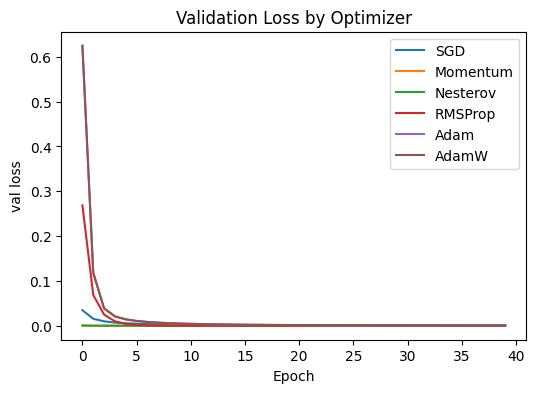

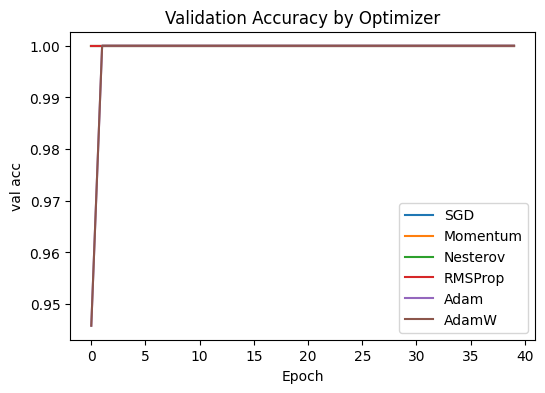

In [41]:
plot_metric(histories, labels, 'val_loss', 'Validation Loss by Optimizer')
plot_metric(histories, labels, 'val_acc', 'Validation Accuracy by Optimizer')

## Experiment B: Regularization ablation (L1/L2/Dropout)
We test None vs. **L2** vs. **L1** vs. **Dropout (p=0.5)**. Keep optimizer fixed for fairness.

In [42]:
histories = []
labels = []

for l1, l2, dropout_p, name in [
    (0.0, 0.0, 0.0, 'none'),
    (0.0, 1e-3, 0.0, 'L2=1e-3'),
    (1e-4, 0.0, 0.0, 'L1=1e-4'),
    (0.0, 0.0, 0.5, 'Dropout p=0.5'),
]:
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=False, dropout_p=dropout_p, init='he', seed=123)
    opt = SGDMomentum(lr=5e-2, momentum=0.9)
    history = train(model, opt, X_train, y_train, X_val, y_val,
                 epochs=40, batch_size=64, l1=l1, l2=l2, early_stopping_patience=5, seed=123, verbose=False)
    val_acc = model.accuracy(X_val, y_val)
    print(f'{name:15s} | val_acc={val_acc:.3f}')

    histories.append(history)
    labels.append(name)

none            | val_acc=1.000
L2=1e-3         | val_acc=1.000
L1=1e-4         | val_acc=1.000
Dropout p=0.5   | val_acc=1.000


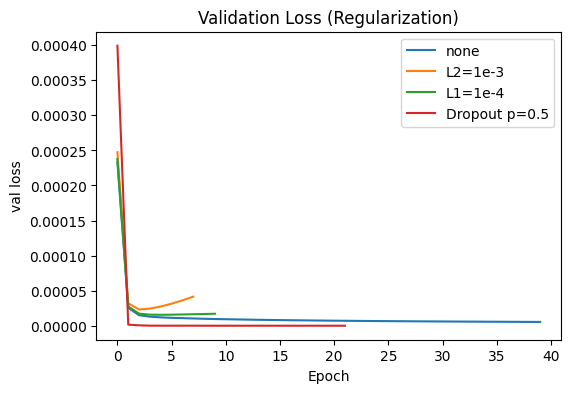

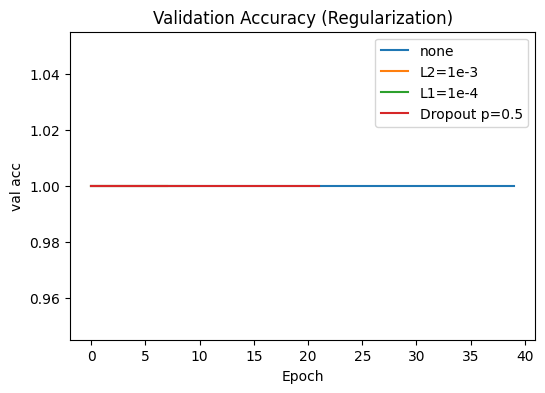

In [43]:
plot_metric(histories, labels, 'val_loss', 'Validation Loss (Regularization)')
plot_metric(histories, labels, 'val_acc', 'Validation Accuracy (Regularization)')

## Experiment C: BatchNorm on/off (with recommended ordering)
Compare MLP **with** vs. **without** BatchNorm (Linear -> BN -> ReLU -> [Dropout]). Keep optimizer and budget fixed.

In [44]:
def run_batch_norm(use_batch_norm, name):
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=use_batch_norm, dropout_p=0.3, init='he', seed=123)
    optimizer = SGDMomentum(lr=5e-2, momentum=0.9)
    history = train(model, optimizer, X_train, y_train, X_val, y_val,
                 epochs=40, batch_size=64, l1=0.0, l2=0.0, early_stopping_patience=5, seed=123, verbose=False)
    val_acc = model.accuracy(X_val, y_val)

    print(f'{name:8s} | val_acc={val_acc:.3f}')
    return history, name

batch_norm_history, _ = run_batch_norm(True, 'with BN')
no_batch_norm_history, _ = run_batch_norm(False, 'no BN')

with BN  | val_acc=1.000
no BN    | val_acc=1.000


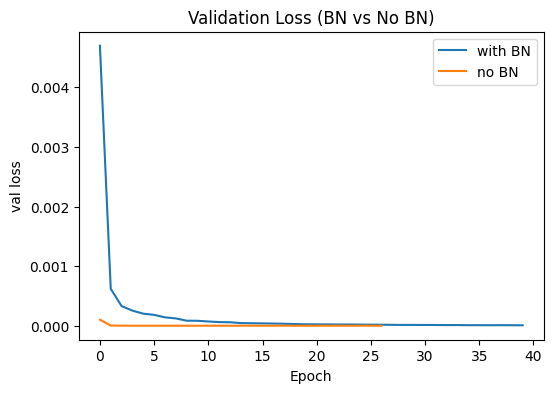

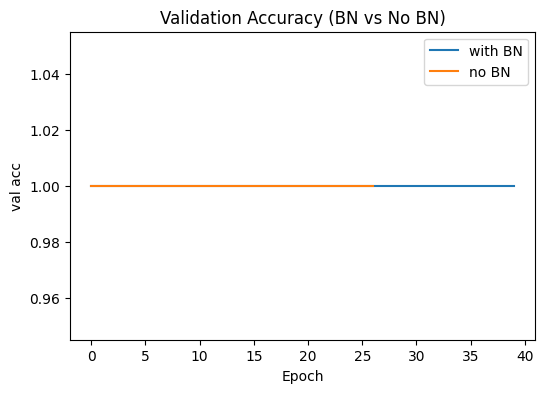

In [45]:
plot_metric([batch_norm_history, no_batch_norm_history], ['with BN', 'no BN'], 'val_loss', 'Validation Loss (BN vs No BN)')
plot_metric([batch_norm_history, no_batch_norm_history], ['with BN', 'no BN'], 'val_acc', 'Validation Accuracy (BN vs No BN)')

## Experiment C: Micro-batch ablation (Gradient Accumulation)
Keep optimizer fixed for fairness; hold logical batch_size constant
and vary micro_batch_size ∈ {None, 32, 16, 8, 4, 1}

no-accum     | val_acc=1.000
micro=32 (x2) | val_acc=1.000
micro=16 (x4) | val_acc=1.000
micro=8  (x8) | val_acc=1.000
micro=4  (x16) | val_acc=1.000
micro=1  (x64) | val_acc=1.000


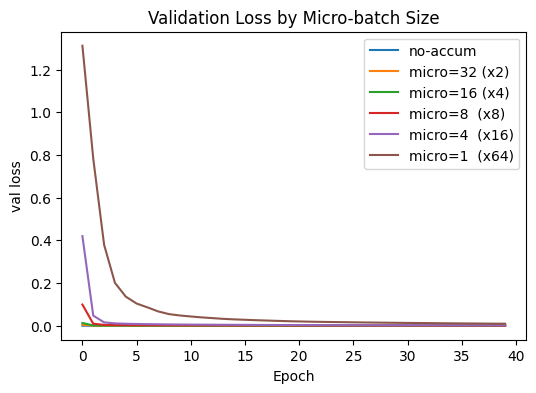

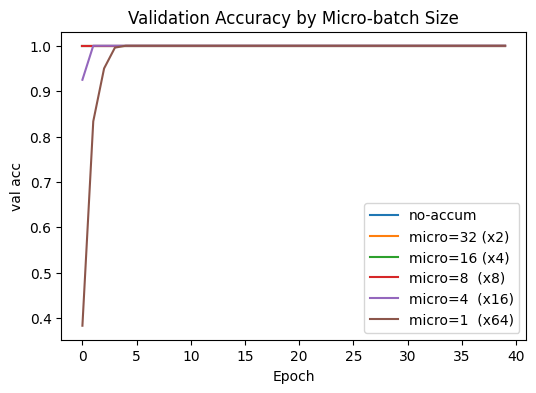

In [46]:
histories_mb = []
labels_mb = []

logical_batch_size = 64   
optimizer_ctor = lambda: SGDMomentum(lr=5e-2, momentum=0.9)  

for micro_bs, name in [
    (None, 'no-accum'),       
    (32,   'micro=32 (x2)'),   
    (16,   'micro=16 (x4)'),
    (8,    'micro=8  (x8)'),
    (4,    'micro=4  (x16)'),
    (1,    'micro=1  (x64)'),
]:
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=False, dropout_p=0.0, init='he', seed=123)

    opt = optimizer_ctor()

    history = train(model, opt, X_train, y_train, X_val, y_val,
                    epochs=40,
                    batch_size=logical_batch_size,      
                    l1=0.0, l2=0.0,
                    early_stopping_patience=5,
                    seed=123,
                    verbose=False,
                    micro_batch_size=micro_bs)           

    val_acc = model.accuracy(X_val, y_val)
    print(f'{name:12s} | val_acc={val_acc:.3f}')

    histories_mb.append(history)
    labels_mb.append(name)

# Plot like before
plot_metric(histories_mb, labels_mb, 'val_loss', 'Validation Loss by Micro-batch Size')
plot_metric(histories_mb, labels_mb, 'val_acc',  'Validation Accuracy by Micro-batch Size')